In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# PART1

### Import dataset

In [2]:
# dataset from lab 2 (standart procedure)
dataset = pd.read_csv('glass.csv')
dataset = dataset.fillna(dataset.mean())
feature_names = list(dataset.columns[:-1])
dataset.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


### split the dataset into train/test  (80/20 proportion) 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(dataset[dataset.columns[:-1]], dataset['Type'], test_size=0.2, random_state=0)
# scale data to improve accuracy
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)

In [4]:
# search for the best parameters 
param_grid = [
        {
            'activation' : ['identity', 'logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [
             (1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,), (12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,)
             ]
        }
       ]

In [5]:
%%capture --no-display
# all warnings because of small dataset
# build MLP model, take parameters from grid search
# in this case, RFC would be better for classifications, because MLP needs more data in train dataset,
# but we have only 214 records
clf = GridSearchCV(MLPClassifier(), param_grid, cv=3,
                           scoring='accuracy')
# fit model
clf.fit(X_trainscaled,y_train)

GridSearchCV(cv=3, estimator=MLPClassifier(),
             param_grid=[{'activation': ['identity', 'logistic', 'tanh',
                                         'relu'],
                          'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                 (6,), (7,), (8,), (9,), (10,),
                                                 (11,), (12,), (13,), (14,),
                                                 (15,), (16,), (17,), (18,),
                                                 (19,), (20,), (21,)],
                          'solver': ['lbfgs', 'sgd', 'adam']}],
             scoring='accuracy')

In [6]:
# best params and accuracy
print('Best params:',clf.best_params_)
print("Test set: ", clf.score(X_testscaled,y_test))

Best params: {'activation': 'logistic', 'hidden_layer_sizes': (16,), 'solver': 'lbfgs'}
Test set:  0.6046511627906976


# PART2

### CNN

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [8]:
# in all csv-s below handwritten digits(name of files)
letters = pd.read_csv("letters/letters.csv")
letters2 = pd.read_csv("letters/letters2.csv")
letters3 = pd.read_csv("letters/letters3.csv")

In [9]:
# prepare data
source = pd.Series([],dtype=object)
letters["source"] = source
letters2["source"] = source
letters3["source"] = source
for i in range(len(letters)): 
    letters["source"][i] = "/letters"
for i in range(len(letters2)): 
    letters2["source"][i] = "/letters2"
for i in range(len(letters3)):
    letters3["source"][i] = "/letters3"

In [10]:
# concat all data from dirs
data = pd.concat((letters, letters2, letters3), axis = 0, ignore_index = True)
print(data.shape)
data.head()

(14190, 5)


,letter,label,file,background,source
0,а,1,01_01.png,0,/letters
1,а,1,01_02.png,0,/letters
2,а,1,01_03.png,0,/letters
3,а,1,01_04.png,0,/letters
4,а,1,01_05.png,0,/letters


In [11]:
data = shuffle(data, random_state = 42).reset_index(drop = True)

In [12]:
# get images from filenames
dirname = "letters"
imgs = []
for i in range(len(data)):
    imgs.append(load_img(os.path.join(dirname + data["source"][i], data["file"][i]), target_size = (32, 32)))

In [13]:
# normalize all images
imgs_array = np.array([img_to_array(img) for img in imgs])/255
print(imgs_array.shape)

(14190, 32, 32, 3)


In [14]:
# both: the letter and the background are considered as labels.
# target = [letter,background]
# background encoding: 0 -> striped 1 => gridded 2 -> no background 3 -> graph paper
targets = []
for i, row in data.iterrows(): 
    t = [data.letter[i], data.background[i]]
    targets.append(t)
targets_array = np.array(targets)

In [15]:
# split the data into train/test (80/20 with validation)
X_train, X_val, y_train, y_val = train_test_split(imgs_array, targets_array, 
                                                test_size=0.2,  
                                                random_state=42)

In [16]:
# transform multilabel classification into singlelabel (one-hot encoding)
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_val = mlb.transform(y_val)

In [17]:
# all possible labels (3 for background, the rest - letters)
for (i, target) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, target))

1. 0
2. 1
3. 2
4. 3
5. а
6. б
7. в
8. г
9. д
10. е
11. ж
12. з
13. и
14. й
15. к
16. л
17. м
18. н
19. о
20. п
21. р
22. с
23. т
24. у
25. ф
26. х
27. ц
28. ч
29. ш
30. щ
31. ъ
32. ы
33. ь
34. э
35. ю
36. я
37. ё


In [18]:
# display letter with proper legend, etc.
def display_image(images, list_of_labels = np.arange(15)): 
    plt.figure(figsize=(12,12))
    for i in list_of_labels: 
        plt.subplot(3, 5, i+1)
        plt.title('Letter: %s \n'%targets[i][0]+\
                    'Background: %s\n'%targets[i][1],
                         fontsize=18)
        plt.imshow(imgs[i])
        
    plt.subplots_adjust(bottom = 0.001)
    plt.subplots_adjust(top = 0.99)
    plt.show()

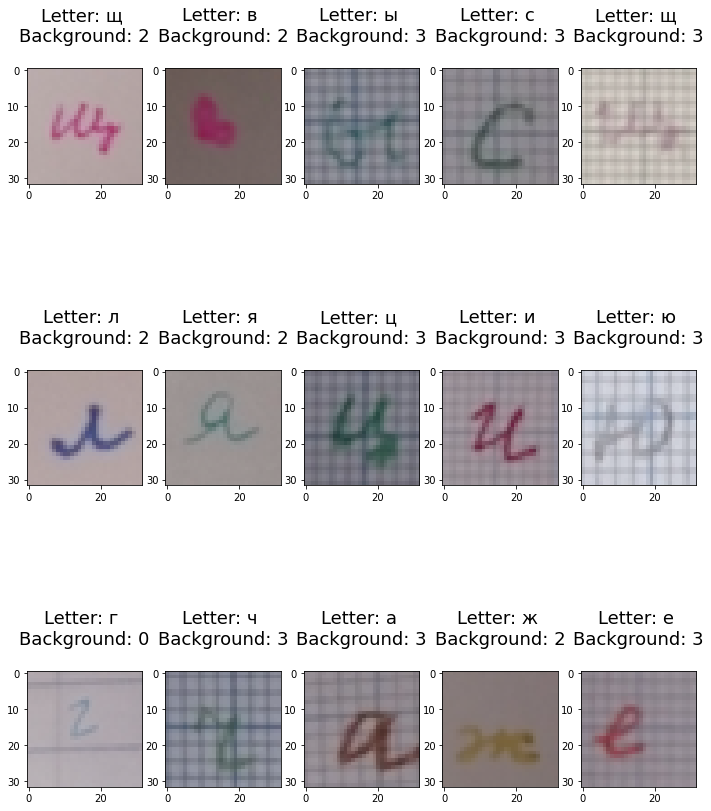

In [19]:
display_image(imgs_array)

In [20]:
# specify image parameters
img_rows = 32
img_cols = 32
channels = 3
classes = len(mlb.classes_)
# build cnn model
model = Sequential()
# add needed layers (standart activation function - f(x) = max(0,x) -  relu)
model.add(Conv2D(64, kernel_size = (3, 3), padding = 'Same',
                     activation = 'relu',
                     input_shape = (img_rows, img_cols, channels)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), padding = 'Same', activation = 'relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding = 'Same', activation = 'relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(128, (3, 3), padding = 'Same', activation = 'relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.25))
# sigmoid for Dense
model.add(Dense(classes, activation='sigmoid'))
# display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0

In [21]:
# compile (loss func - cross-entropy, standart optimizer  - adam, and standart accuracy metrics)
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
# image adjustments
aug = ImageDataGenerator(
        rotation_range=5, 
        zoom_range = 0.2, 
        width_shift_range=0.2,  
        height_shift_range=0.2 
        )

In [23]:
# define stop condition for optimization
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)

In [24]:
# BS - Batch size
# for better results we should take more epochs, but it takes so much time
# verbose = 1 for optimization process clearness
BS = 32
EPOCHS = 10
# save loss function values on each iteration to make plot 
history = model.fit(x=aug.flow(X_train, y_train, batch_size = BS),
                    steps_per_epoch = len(X_train)//BS,   
                    epochs = EPOCHS,
                    verbose = 1,
                    validation_data = (X_val, y_val), callbacks=[early_stop])

Epoch 1/10
354/354 [==============================] - 31s 88ms/step - loss: 0.1493 - accuracy: 0.8261 - val_loss: 0.3698 - val_accuracy: 0.4140
Epoch 2/10
354/354 [==============================] - 31s 89ms/step - loss: 0.1174 - accuracy: 0.9034 - val_loss: 0.1342 - val_accuracy: 0.8767
Epoch 3/10
354/354 [==============================] - 30s 84ms/step - loss: 0.0966 - accuracy: 0.9315 - val_loss: 0.1468 - val_accuracy: 0.6318
Epoch 4/10
354/354 [==============================] - 24s 68ms/step - loss: 0.0774 - accuracy: 0.9382 - val_loss: 0.0657 - val_accuracy: 0.9193
Epoch 5/10
354/354 [==============================] - 24s 69ms/step - loss: 0.0622 - accuracy: 0.9371 - val_loss: 0.1150 - val_accuracy: 0.7216
Epoch 6/10
354/354 [==============================] - 24s 68ms/step - loss: 0.0528 - accuracy: 0.9307 - val_loss: 0.1219 - val_accuracy: 0.5948
Epoch 7/10
354/354 [==============================] - 26s 73ms/step - loss: 0.0460 - accuracy: 0.9351 - val_loss: 0.0555 - val_accuracy:

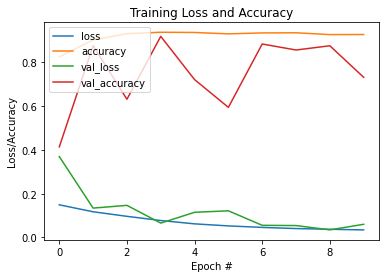

In [25]:
# plot loss function
loss_accuracy = pd.DataFrame(model.history.history)
loss_accuracy.plot()
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [26]:
# decode single label problem to multilabel and compute accuracy
predictions = model.predict(X_val)
predictions[predictions>0.5] = 1
predictions[predictions<=0.5] = 0
pred_results = mlb.inverse_transform(predictions)
true_results = mlb.inverse_transform(y_val)

In [27]:
accuracy = sum([pred_results[i] == true_results[i] for i in range(len(y_val)) if pred_results[i] == true_results[i]])/len(y_val)
print("Accuracy: ", accuracy)

Accuracy:  0.5429880197322058


In [28]:
# save model 
model.save("cnn_handwritten_letters_model.h5")
print("Saved!")

Saved!


# PART3

### RNN

In [64]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import  load_files
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM

In [65]:
# download set of stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ruslankhomenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [66]:
# data from lab3 (movie reviews and labels: positive and negative)
movie_data = load_files(r"../lab3/review_polarity/txt_sentoken/")
data, target = movie_data.data, movie_data.target

In [67]:
df = pd.DataFrame()
df['review'],df['label'] = data,target
df['review'] = df['review'].str.decode('utf8');

In [68]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile(b'[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile(b'[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [69]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text
df['review'] = df['review'].apply(clean_text)

In [70]:
# The maximum number of words to be used.
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
# tokenize text
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
# fit tokenizer on review text
tokenizer.fit_on_texts(df['review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 46980 unique tokens.


In [71]:
# pad sequences to make length of all features the same 
X = tokenizer.texts_to_sequences(df['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2000, 250)


In [72]:
# create labels vector
Y = pd.get_dummies(df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2000, 2)


In [73]:
# split data into train/test samples (90/10 proportions)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1800, 250) (1800, 2)
(200, 250) (200, 2)


In [74]:
# build RNN model
model = Sequential()
# add layers
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# add dropout to avoid overfitting
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/10
26/26 [==============================] - 10s 386ms/step - loss: 0.6911 - accuracy: 0.5407 - val_loss: 0.6832 - val_accuracy: 0.5944
Epoch 2/10
26/26 [==============================] - 10s 379ms/step - loss: 0.6097 - accuracy: 0.7593 - val_loss: 0.5985 - val_accuracy: 0.7056
Epoch 3/10
26/26 [==============================] - 7s 255ms/step - loss: 0.2217 - accuracy: 0.9389 - val_loss: 0.4482 - val_accuracy: 0.8056
Epoch 4/10
26/26 [==============================] - 6s 249ms/step - loss: 0.0272 - accuracy: 0.9951 - val_loss: 0.4974 - val_accuracy: 0.8167
Epoch 5/10
26/26 [==============================] - 7s 252ms/step - loss: 0.0074 - accuracy: 0.9994 - val_loss: 0.7106 - val_accuracy: 0.7556
Epoch 6/10
26/26 [==============================] - 7s 252ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.6109 - val_accuracy: 0.7833


In [75]:
# accuracy of our model
accuracy = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

7/7 [==============================] - 0s 27ms/step - loss: 0.6996 - accuracy: 0.7750
Test set
  Loss: 0.700
  Accuracy: 0.775


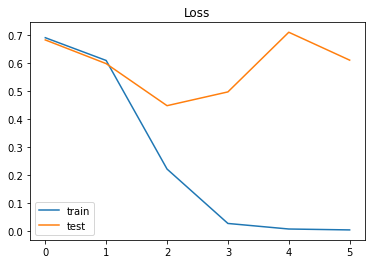

In [76]:
# loss_function = loss_function(iteration number)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

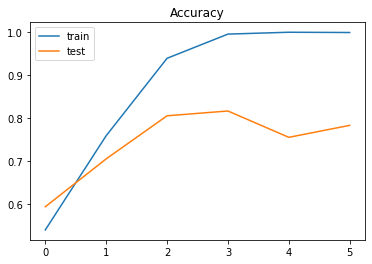

In [77]:
# accuracy as a function of iteration
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();